# Importing Common Libraries

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from datetime import timedelta
from datetime import time
from datetime import datetime

# Importing Special Libraries

## Quandl

In [2]:
# https://algotrading101.com/learn/quandl-guide/
import quandl
quandl.ApiConfig.api_key = 'U4m2As16aHLxEiSQtGvn'## API Key provided after creating free ID on Quaqndl
quandl.save_key("U4m2As16aHLxEiSQtGvn")

## bselib

In [3]:
# https://bselib.readthedocs.io/en/latest/
from bselib.bse import BSE
bselib = BSE()

# Data Extraction

## Company 1: Reliance

In [18]:
data1=quandl.get('BSE/BOM500325',start_date='1992/03/05')
pd.DataFrame(data1['Open']).to_excel('data/Reliance.xlsx')

In [92]:
reliance=pd.read_excel('data/Reliance.xlsx')
reliance.tail(5)

,Date,Open
7099,2021-04-30,2014.7
7100,2021-05-03,1963.7
7101,2021-05-04,1954.0
7102,2021-05-05,1919.7
7103,2021-05-06,1926.0


### Updating data if current day is a Business Day

In [20]:
def is_business_day(date):
    return bool(len(pd.bdate_range(date, date)))

In [102]:
if is_business_day(date.today()):
    df=reliance
    df.loc[len(df.index)]=[datetime(date.today().year,date.today().month,date.today().day),float(bselib.quote('500325')['lastOpen'])]
    df=df.set_index('Date')
df.tail(10)

,Open
Date,
2021-04-27,1943.00
2021-04-28,1999.45
2021-04-29,2016.65
2021-04-30,2014.70
2021-05-03,1963.70
2021-05-04,1954.00
2021-05-05,1919.70
2021-05-06,1926.00
2021-05-07,1940.00


<AxesSubplot:xlabel='Date'>

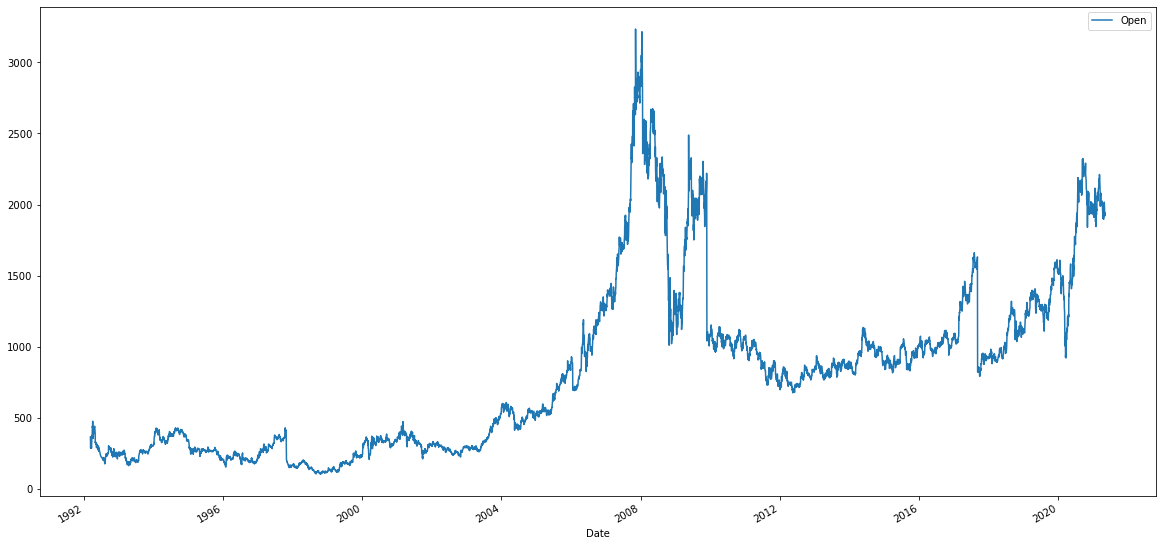

In [99]:
df.plot(figsize=(20,10))

In [6]:
# Financial Ratios
ratios = bselib.ratios(500325)
ratios=pd.DataFrame(ratios)
ratios

,value_ratio,profit_ratio
SecurityId,RELIANCE,NaN
Grp_Index,A / S&P BSE SENSEX,NaN
FaceVal,10.00,NaN
SecurityCode,500325,NaN
ISIN,INE002A01018,NaN
Industry,Integrated Oil & Gas,NaN
Group,A,NaN
Index,S&P BSE SENSEX,NaN
PAIDUP_VALUE,,NaN
EPS,48.13,48.13


In [7]:
# News
news = bselib.news(500325)
news

{'news': [{'newsid': '1f1d12e720d2dcf232bfd5b270fc4e99',
   'category': '',
   'description': 'RILs Rs 53,124-cr rights: Partly paid premium shrinks as call date nears  Business Standard',
   'imagepath': '',
   'link': 'https://www.business-standard.com/article/markets/ril-s-rs-53-124-cr-rights-partly-paid-premium-shrinks-as-call-date-nears-121050401025_1.html',
   'newstype': 'STKNWS',
   'publisheddate': '04-May-2021 19:00',
   'source': 'https://www.business-standard.com',
   'stockid': 605152,
   'title': 'RILs Rs 53,124-cr rights: Partly paid premium shrinks as call date nears'},
  {'newsid': '33779c2e86447b43acbe4115f26f4d12',
   'category': '',
   'description': 'Stocks to Watch: RIL, Adani Ports and SEZ, ICICI Bank, Bajaj Auto  Mint',
   'imagepath': '',
   'link': 'https://www.livemint.com/market/stock-market-news/stocks-to-watch-ril-adani-ports-and-sez-icici-bank-bajaj-auto-11620091949109.html',
   'newstype': 'STKNWS',
   'publisheddate': '04-May-2021 07:30',
   'source': '

# Factor 1: Daily Price Prediction

In [107]:
training_set=df.iloc[:,0:1].values
training_set

array([[ 365.],
       [ 330.],
       [ 285.],
       ...,
       [1926.],
       [1940.],
       [1940.]])

In [108]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1),copy=True)
training_set_scaled=sc.fit_transform(training_set)
training_set_scaled

array([[0.08374038],
       [0.07256648],
       [0.05820004],
       ...,
       [0.58209622],
       [0.58656578],
       [0.58656578]])

### Creating a data structure with 60 timesteps and 1 output

In [109]:
import numpy as np
X_train=[]
y_train=[]
for i in range(60,len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)

### Reshaping

In [110]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [111]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Initialising the RNN

In [120]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation

In [121]:
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

### Adding a second LSTM layer and some Dropout regularisation

In [122]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a third LSTM layer and some Dropout regularisation

In [123]:
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

### Adding a fourth LSTM layer and some Dropout regularisation

In [124]:
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

### Adding the output layer

In [125]:
regressor.add(Dense(units = 1))

### Compiling the RNN

In [126]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the RNN to the Training set

In [127]:
regressor.fit(X_train, y_train, epochs = 25, batch_size = 32)

Epoch 1/25
221/221 [==============================] - 17s 49ms/step - loss: 0.0077
Epoch 2/25
221/221 [==============================] - 14s 65ms/step - loss: 0.0016
Epoch 3/25
221/221 [==============================] - 14s 65ms/step - loss: 0.0014
Epoch 4/25
221/221 [==============================] - 15s 67ms/step - loss: 0.0012
Epoch 5/25
221/221 [==============================] - 15s 69ms/step - loss: 0.0011
Epoch 6/25
221/221 [==============================] - 15s 68ms/step - loss: 0.0011
Epoch 7/25
221/221 [==============================] - 15s 68ms/step - loss: 0.0010
Epoch 8/25
221/221 [==============================] - 14s 65ms/step - loss: 7.9847e-04
Epoch 9/25
221/221 [==============================] - 15s 66ms/step - loss: 8.4273e-04
Epoch 10/25
221/221 [==============================] - 14s 66ms/step - loss: 8.1579e-04
Epoch 11/25
221/221 [==============================] - 14s 66ms/step - loss: 7.5034e-04
Epoch 12/25
221/221 [==============================] - 15s 67ms/step 

In [128]:
y_pred=regressor.predict(X_train)
y_pred=sc.inverse_transform(y_pred)

In [129]:
y_real=sc.inverse_transform([y_train])

In [151]:
results=pd.concat([pd.DataFrame(y_real).T,pd.DataFrame(y_pred)],axis='columns')
results.columns=['Real Price','Predicted Price']
results.tail(5)

,Real Price,Predicted Price
7041,1954.0,1898.183350
7042,1919.7,1877.308960
7043,1926.0,1851.774048
7044,1940.0,1836.009766
7045,1940.0,1835.750000


In [152]:
l=df.index
l=l[60:]
results.index=l
results.tail(10)

,Real Price,Predicted Price
Date,,
2021-04-27,1943.00,1821.004150
2021-04-28,1999.45,1831.771484
2021-04-29,2016.65,1858.645630
2021-04-30,2014.70,1888.614624
2021-05-03,1963.70,1906.934570
2021-05-04,1954.00,1898.183350
2021-05-05,1919.70,1877.308960
2021-05-06,1926.00,1851.774048
2021-05-07,1940.00,1836.009766


<AxesSubplot:xlabel='Date'>

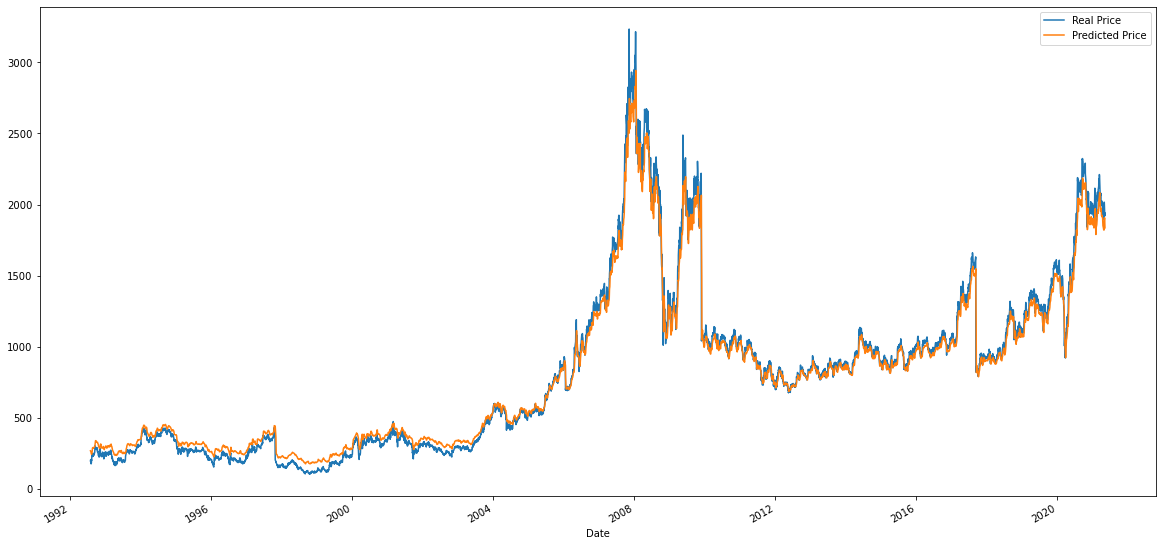

In [153]:
results.plot(figsize=(20,10))

### Tomorrow's Prediction

In [167]:
X_test=[]
X_test.append(training_set_scaled[len(training_set_scaled)-60:len(training_set_scaled),0])
X_test=np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test=regressor.predict(X_test)
y_test=sc.inverse_transform(y_test)

In [168]:
y_test

array([[1843.0377]], dtype=float32)